In [1]:
# %load ./scripts_cp/fig_likelihood_gaussgauss.py
"""
Gaussian Distribution with Gaussian Errors
------------------------------------------
Figure 5.7

The logarithm of the posterior probability density function for :math:`\mu`
and :math:`\sigma`, :math:`L_p(\mu,\sigma)`, for a Gaussian distribution with
heteroscedastic Gaussian measurement errors (sampled uniformly from the 0-3
interval), given by eq. 5.64. The input values are :math:`\mu = 1` and
:math:`\sigma = 1`, and a randomly generated sample has 10 points. Note that
the posterior pdf is not symmetric with respect to the :math:`\mu = 1` line,
and that the outermost contour, which encloses the region that contains 0.997
of the cumulative (integrated) posterior probability, allows solutions with
:math:`\sigma = 0`.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)


def gaussgauss_logL(xi, ei, mu, sigma):
    """Equation 5.63: gaussian likelihood with gaussian errors"""
    ndim = len(np.broadcast(sigma, mu).shape)

    xi = xi.reshape(xi.shape + tuple(ndim * [1]))
    ei = ei.reshape(ei.shape + tuple(ndim * [1]))

    s2_e2 = sigma ** 2 + ei ** 2
    return -0.5 * np.sum(np.log(s2_e2) + (xi - mu) ** 2 / s2_e2, 0)

#------------------------------------------------------------
# Define the grid and compute logL
np.random.seed(5)
mu_true = 1.
sigma_true = 1.
N = 10
ei = 3 * np.random.random(N)
xi = np.random.normal(mu_true, np.sqrt(sigma_true ** 2 + ei ** 2))

sigma = np.linspace(0.01, 5, 70)
mu = np.linspace(-3, 5, 70)

logL = gaussgauss_logL(xi, ei, mu, sigma[:, np.newaxis])
logL -= logL.max()

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 3.75))
plt.imshow(logL, origin='lower',
           extent=(mu[0], mu[-1], sigma[0], sigma[-1]),
           cmap=plt.cm.binary,
           aspect='auto')
plt.colorbar().set_label(r'$\log(L)$')
plt.clim(-5, 0)

plt.text(0.5, 0.93,
         (r'$L(\mu,\sigma)\ \mathrm{for}\ \bar{x}=1,\ '
          r'\sigma_{\rm true}=1,\ n=10$'),
         bbox=dict(ec='k', fc='w', alpha=0.9),
         ha='center', va='center', transform=plt.gca().transAxes)

plt.contour(mu, sigma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='k')

plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

plt.show()


# Bayesian Statistical Inference: II

*S. R. Taylor (2024)*

Material in this lecture and notebook is based upon the "Introduction To Bayesian Inference" lectures of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18). Also the "Inference" and "Inference2" lectures of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), Karen Leighly's [Bayesian Stats](http://seminar.ouml.org/lectures/bayesian-statistics/), and J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.
- [Jake VanderPlas's workshop "Bayesian Astronomy"](https://github.com/jakevdp/BayesianAstronomy)
- [Jake VanderPlas's blog "Frequentism and Bayesianism: A Practical Introduction"](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)


##### Highly recommended supplemental background reading:

- [David Hogg's "Fitting A Model To Data"](https://arxiv.org/abs/1008.4686)
- [Jake VanderPlas: "Frequentism and Bayesianism: A Python-driven Primer"](https://arxiv.org/abs/1411.5018)


##### For those who want to dive deep:

- [D. Sivia and J. Skilling: "Data Analysis: A Bayesian Tutorial"](https://www.amazon.com/Data-Analysis-Bayesian-Devinderjit-Sivia/dp/0198568320)
- [E.T. Jaynes: "Probability Theory: The Logic of Science"](http://bayes.wustl.edu/etj/prob/book.pdf)
- [E.T. Jaynes: "Confidence Intervals vs. Bayesian intervals"](http://bayes.wustl.edu/etj/articles/confidence.pdf)
- [This great explanation of confidence levels versus credible regions on Stackexchange](https://stats.stackexchange.com/questions/2272/whats-the-difference-between-a-confidence-interval-and-a-credible-interval/2287#2287)

---

## Contents
* [Simple parameter estimation examples](#one)
    * [Underlying Gaussian distribution with heteroscedastic Gaussian uncertainties](#onea)
    * [Gaussian distribution embedded in a uniform background distribution](#oneb)
* [Bayesian Model Comparison](#two)
    * [Example of Cauchy Versus Gaussian Model Comparison](#twoa)
    * [Example of Coin Flip Bayesian Model Comparison](#twob)
* [Approximate Bayesian Model Comparison & Information Criterion Proxies](#three)


---


***Exercises required for class participation are in <font color='red'>red</font>.***

---

## Simple parameter estimation examples <a class="anchor" id="one"></a>

### Underlying Gaussian distribution with heteroscedastic Gaussian uncertainties <a class="anchor" id="onea"></a>

The final example we saw in the previous lecture dealt with Bayesian parameter estimation of a Gaussian distribution, for $\mu$ and $\sigma$. **But what if the values we measure $\{x_i\}$ also have a measurement uncertainty?** We're dealing with two levels of spread then:

- the underlying distribution spread, $\sigma$, and 
- the measurement uncertainties of the data, $\{e_i\}$

The measurement uncertainties further blur the underlying distribution. In fact, if the uncertainties are homoscedastic, the distribution of $\{x_i\}$ will be Gaussian, ***BUT*** **if the uncertainties are heteroscedastic the distribution of $\{x_i\}$ will be non-Gaussian!**

- The figure below shows a distribution of $10^6$ points drawn from $\mathcal{N}(0,1)$ and sampled with heteroscedastic Gaussian errors with widths, $e_i$, uniformly distributed between $0$ and $3$. 
- A linear superposition of these Gaussian distributions with widths equal to $\sqrt{1 + e_i^2}$ results in a non-Gaussian distribution. 
- The best-fit Gaussians centered on the sample median with widths equal to sample standard deviation and quartile-based $\sigma_G$ are shown for comparison.

![](https://www.astroml.org/_images/fig_distribution_gaussgauss_1.png)

We're trying to find the $\mu$ and $\sigma$ parameters of the underlying distribution. With uniform priors on each, the log-posterior pdf can be written as

$$ \ln p = \mathrm{constant} - \frac{1}{2}\sum_{i=1}^N \left( \ln(\sigma^2+e_i^2) + \frac{(x_i-\mu)^2}{(\sigma^2+e_i^2)} \right), $$

which looks identical to the log-likelihood $\ln L$ up to a constant due to the uniform priors. We can actually analytically maximize this to find the MAP (maximum a posteriori) value of $\mu_0$,

$$ \mu_0 = \frac{\sum_{i=1}^N x_i / (\sigma_0^2 + e_i^2)}{\sum_{i=1}^N 1 / (\sigma_0^2 + e_i^2)} $$

but a closed-form analytic solution for $\sigma_0$ does not exist. 

So we resort to numerical methods and just plot $\ln p$ on a grid. <font color='red'>Execute the following to produce the log-posterior pdf of parameters $\mu$ and $\sigma$ of an underlying Gaussian distribution. The dataset has $N=10$ values, drawn from $\mu=1$, $\sigma=1$, each measured with an uncertainty drawn from a uniform distribution $0<e_i<3$.</font>

/Users/howarn1/anaconda3/envs/astr8070/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


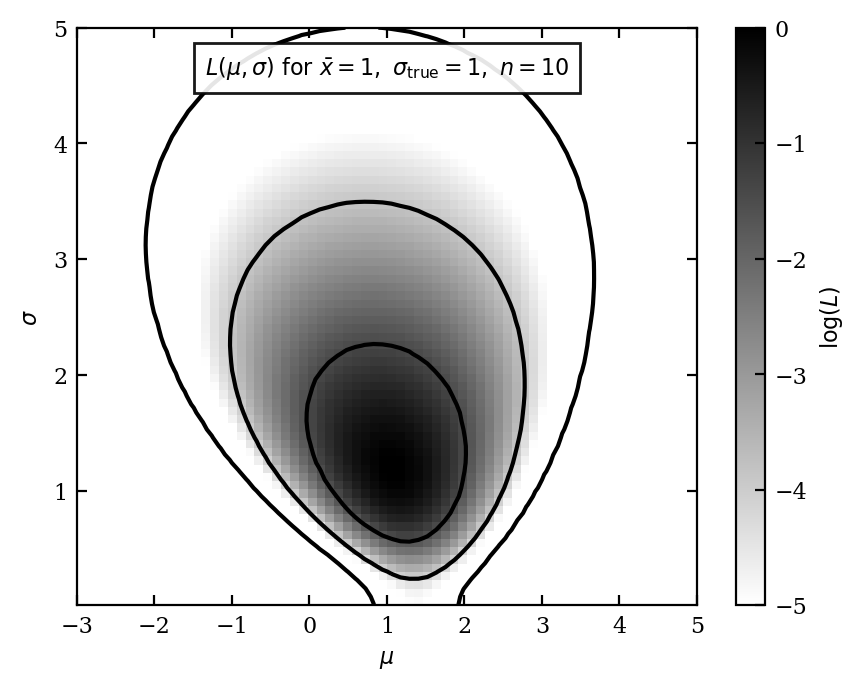

<Figure size 640x480 with 0 Axes>

In [2]:
# Execute this cell
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
np.random.seed(42)

%run ./scripts_cp/fig_likelihood_gaussgauss.py

<font color='red'>By eye, are $\mu=1$, $\sigma=1$ the MAP parameter values? If not, is this a problem? Discuss.</font>
# Looks like 1.6 and 1.6

**Key takeaways**
- The posterior pdf is not symmetric around $\mu=1$.
- In fact it is consistent within the $99.7\%$ credible region of having $\sigma=0$. 
- The marginal distributions of each parameter would not look Gaussian either.

---

### Gaussian distribution embedded in a uniform background distribution <a class="anchor" id="oneb"></a>

What if we wanted to **model the mixture of a Gauassian distribution with a uniform distribution**. When might that be useful?  Well, for example, finding new particles!! The following is from the [Atlas bulletin](https://atlas.cern/updates/feature/higgs-boson) of July 4th, 2018, showing the Higgs boson peak embdded in background noise and other particles.

![Atlas Higgs Boson Example](https://cds.cern.ch/record/2627611/files/Higgsto4l.png?subformat=icon-640)

Obviously this isn't *exactly* a Gaussian and a uniform distribution, but a line feature superimposed upon a background is the sort of thing that a physicist or astronomer might see and is pretty close to this case for a local region around the feature of interest. <font color='red'>Spend a moment discussing similar problems in your research areas that are like this.</font>

Let's assume that 
- the location parameter, $\mu$, is known (say from theory) and
- the uncertainties in $x_i$ are negligible compared to $\sigma$.

The likelihood of obtaining a single measurement, $x_i$, can be written as a probabilistic mixture of *either* the Gaussian *or* the uniform distribution. Hence, we use the **OR Rule** of probability:

$$p(x_i|A,\mu,\sigma,I) = \frac{A}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right) + \frac{1-A}{W}.$$

- Here the background probability is taken to be $0 < x < W$ and 0 otherwise.  
- The feature of interest lies between $0$ and $W$.  
- $A$ and $1-A$ are the relative strengths of the two components, which are obviously anti-correlated.  
- Note that there will be covariance between $A$ and $\sigma$. 

If we adopt a uniform prior in both $A$ and $\sigma$:

$$p(A,\sigma|I) = C, \; {\rm for} \; 0\le A<A_{\rm max} \; {\rm and} \; 0 \le \sigma \le \sigma_{\rm max},$$

then the posterior pdf is given by

$$\ln [p(A,\sigma|\{x_i\},\mu,W)] = \sum_{i=1}^N \ln \left[\frac{A}{\sigma \sqrt{2\pi}} \exp\left( \frac{-(x_i-\mu)^2}{2\sigma^2} \right)  + \frac{1-A}{W} \right].$$

The example below is for $200$ data points with $A=0.5, \sigma=1, \mu=5, W=10$. Specifically, the bottom panel is a result drawn from this distribution and the top panel is the likelihood distribution derived from the data in the bottom panel.

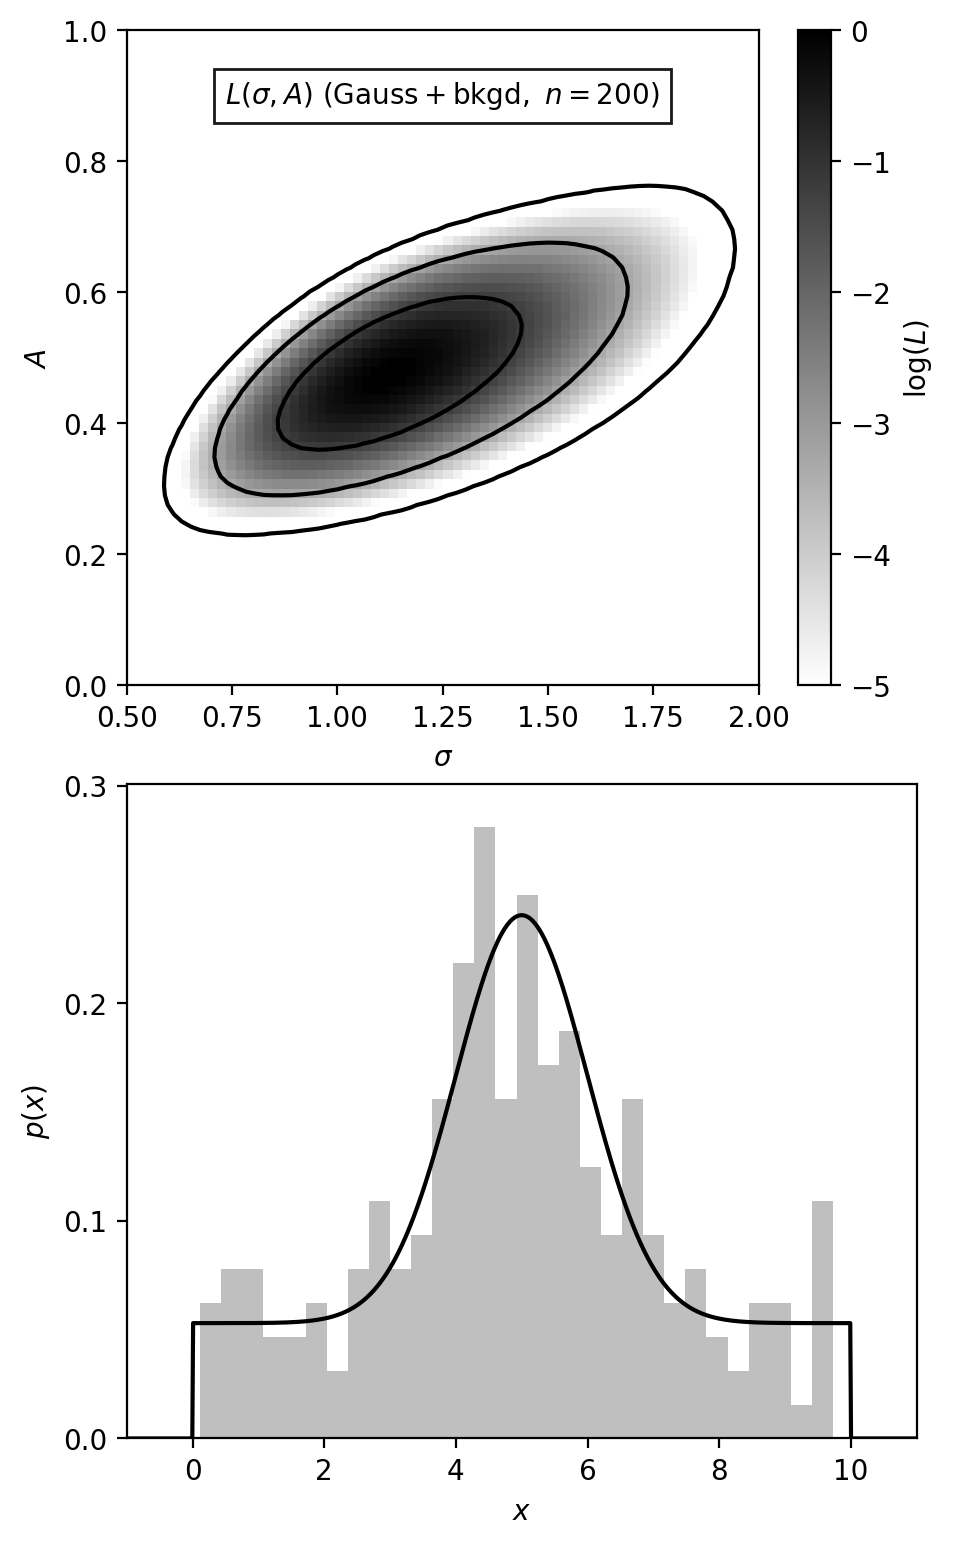

In [3]:
# %load ./scripts/fig_likelihood_gausslin.py
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from scipy.stats import truncnorm, uniform
from astroML.plotting.mcmc import convert_to_stdev

def gausslin_logL(xi, A=0.5, sigma=1.0, mu=5.0, L=10.0):
    """Equation 5.80: gaussian likelihood with uniform background"""
    xi = np.asarray(xi)

    shape = np.broadcast(sigma, A, mu, L).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return np.sum(np.log(A * np.exp(-0.5 * ((xi - mu) / sigma) ** 2)
                         / (sigma * np.sqrt(2 * np.pi))
                         + (1. - A) / L), 0)

#------------------------------------------------------------
# Define the distribution
np.random.seed(0)
mu = 5.0
sigma = 1.0
L = 10.0
A = 0.5
N = 200

xi = np.random.random(N)
NA = np.sum(xi < A)

dist1 = truncnorm((0 - mu) / sigma, (L - mu) / sigma, mu, sigma)
dist2 = uniform(0, 10)

xi[:NA] = dist1.rvs(NA)
xi[NA:] = dist2.rvs(N - NA)

x = np.linspace(-1, 11, 1000)
fracA = NA * 1. / N

#------------------------------------------------------------
# define the (sigma, A) grid and compute logL
sigma = np.linspace(0.5, 2, 70)
A = np.linspace(0, 1, 70)

logL = gausslin_logL(xi, A[:, np.newaxis], sigma)
logL -= logL.max()

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 8))
fig.subplots_adjust(bottom=0.07, left=0.11, hspace=0.15, top=0.95)

ax = fig.add_subplot(211)
plt.imshow(logL, origin='lower', aspect='auto',
           extent=(sigma[0], sigma[-1], A[0], A[-1]),
           cmap=plt.cm.binary)
plt.colorbar().set_label(r'$\log(L)$')
plt.clim(-5, 0)
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$A$')

ax.text(0.5, 0.9, r'$L(\sigma,A)\ (\mathrm{Gauss + bkgd},\ n=200)$',
        bbox=dict(ec='k', fc='w', alpha=0.9),
        ha='center', va='center', transform=plt.gca().transAxes)

ax.contour(sigma, A, convert_to_stdev(logL),
           levels=(0.683, 0.955, 0.997),
           colors='k')

ax2 = plt.subplot(212)
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax2.plot(x, fracA * dist1.pdf(x) + (1. - fracA) * dist2.pdf(x), '-k')
ax2.hist(xi, 30, density=True, histtype='stepfilled', fc='gray', alpha=0.5)

ax2.set_ylim(0, 0.301)
ax2.set_xlim(-1, 11)

ax2.set_xlabel('$x$')
ax2.set_ylabel('$p(x)$')
plt.show()

A more realistic example might be one where all three parameters are unknown: the location, the width, and the background level. *But that will have to wait until we learn about MCMC numerical techniques.*

---

## Bayesian Model Comparison <a class="anchor" id="two"></a>

Model comparison and hypothesis testing in Bayesian inference are enormously different from classical/frequentist statistics. ***In Bayesian inference, we probabilistically rank models based on how well they explain the data under our prior knowledge.*** Let's look back at how we assessed goodness-of-fit and model choice in frequentist statistics. 

Let's use the example from http://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/
to illustrate some ideas about model selection.

In [4]:
#Execute this cell to load all of the modules we'll need and define the data array.
from scipy import stats
from scipy import optimize

# generate (x,y, sigma_y) "data" 
data = np.array([[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                   0.09,  0.19,  0.35,  0.4 ,  0.54,
                   0.42,  0.69,  0.2 ,  0.88,  0.03,
                   0.67,  0.42,  0.56,  0.14,  0.2  ],
                 [ 0.33,  0.41, -0.25,  0.01, -0.05,
                  -0.05, -0.12,  0.26,  0.29,  0.39, 
                   0.31,  0.42, -0.01,  0.58, -0.2 ,
                   0.52,  0.15,  0.32, -0.13, -0.09 ],
                 [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]])

In [5]:
#Functions to do a polynomial fit, compute the likelihood, and determine the best-fit parameters.
#Nothing for you to do, just run.  (But see if you can follow what is going on.)
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(degree, model=polynomial_fit, data=data):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, data, model)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

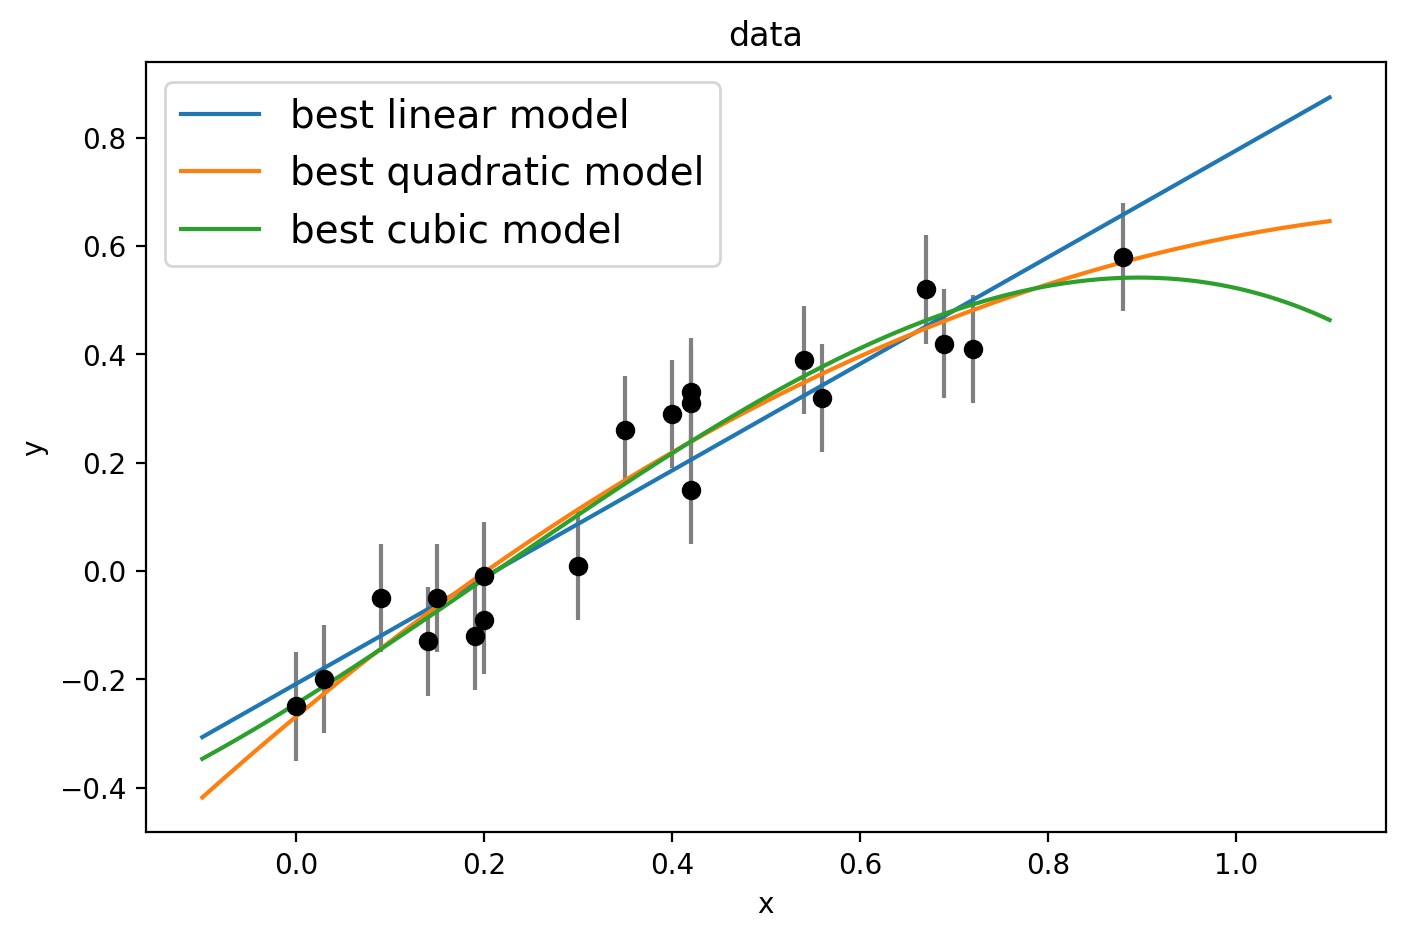

In [6]:
#Execute this cell.  See if you understand what it is doing.
x, y, sigma_y = data
Ndata = x.size

# get best-fit parameters for linear, quadratic and cubic models
theta1 = best_theta(1, data=data)
theta2 = best_theta(2, data=data)
theta3 = best_theta(3, data=data)
# generate best fit lines on a fine grid 
xgrid = np.linspace(-0.1, 1.1, 1000)
yfit1 = polynomial_fit(theta1, xgrid)
yfit2 = polynomial_fit(theta2, xgrid)
yfit3 = polynomial_fit(theta3, xgrid)

# plot 
fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xgrid, yfit1, label='best linear model')
ax.plot(xgrid, yfit2, label='best quadratic model')
ax.plot(xgrid, yfit3, label='best cubic model')
ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');

We can use $\chi^2$ per degree of freedom to determine which fit is "best".  It is computed as 

$$ \chi^2_\mathrm{dof}  = \frac{1}{N-k} \sum_i^N \left( \frac{y - y_\mathrm{fit}}{\sigma_y} \right)^2, $$

where $N$ is the number of data points and $k$ is the number of free model parameters (here 2, 3, and 4).

For large values of $(N-k)$ (larger than about 10), the distribution of 
$\chi^2$ per degre of freedom is approximately Gaussian with a width of
$\sigma=\sqrt{2/(N-k)}$. 

<font color='red'>Complete and execute this cell to compute $\chi^2$ and $\chi^2_\mathrm{dof}$.</font>

In [7]:
#Complete and execute this cell to compute chi2: sum{[(y-yfit)/sigma_y]^2} 
chi21 = np.sum(((y-polynomial_fit(theta1, x))/sigma_y)**2) 
chi22 = np.sum(((y-polynomial_fit(theta2, x))/sigma_y)**2) 
chi23 = np.sum(((y-polynomial_fit(theta3, x))/sigma_y)**2) 
# normalize by the number of degrees of freedom
# the number of fitted parameters is 2, 3, 4
chi2dof1 = chi21/(Ndata - 2)
chi2dof2 = chi22/(Ndata - 3)
chi2dof3 = chi23/(Ndata - 4)

print("CHI2:")
print('   best linear model:', chi21)
print('best quadratic model:', chi22)
print('    best cubic model:', chi23)
print("CHI2 per degree of freedom:")
print('   best linear model:', chi2dof1)
print('best quadratic model:', chi2dof2)
print('    best cubic model:', chi2dof3)

CHI2:
   best linear model: 11.499462014956965
best quadratic model: 9.291258246116401
    best cubic model: 8.979208294682907
CHI2 per degree of freedom:
   best linear model: 0.6388590008309425
best quadratic model: 0.5465446027127294
    best cubic model: 0.5612005184176817


**Which model should we adopt?**

Obviously, the cubic model has the lowest $\chi2$ ("fits the best"), but 
it has 4 free parameters while the linear model has only 2 free parameters.

**How do we trade improvement in $\chi^2$ with increasing model complexity?**

**Occam’s razor:**
> *All else being equal (i.e., each model fits the data equally well), the less complex model is favored.*

This principle was already known to [Ptolemy](https://www.wikiwand.com/en/Ptolemy) (circa 100-170 AD) who said: *“We consider it a good principle to explain the phenomena by the simplest hypothesis possible.”*

## Bayesian Model Comparison

We start with Bayes' Theorem,

$$ \mathrm{Posterior} = \frac{\mathrm{Likelihood}\times\mathrm{Prior}}{\mathrm{Evidence}} $$

$$p(M,\theta \,|\,D,I) = \frac{p(D\,|\,M,\theta,I)\,\times p(M,\theta\,|\,I)}{p(D\,|\,I)},$$

and marginalize over model parameter space $\theta$
to obtain **the probability of model $M$** given the data $D$ and prior information $I$:

$$p(M\,|\,D,I) \equiv \int p(M,\theta \,|\,D,I) \, d\theta = 
      \int \frac{p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)}{p(D\,|\,I)} \, d\theta =
      \frac{p(M\,|\,I)}{p(D\,|\,I)} \int p(D\,|\,M,\theta,I)\,p(\theta\,|\,M,I) \, d\theta  $$
 
 
#### Odds Ratios \& Bayes Factors

To determine which model is better we compute the ratio of the posterior probabilities or the **odds ratio** for two models as

$$O_{21} \equiv \frac{p(M_2|D,I)}{p(M_1|D,I)}.$$

The posterior probability that the model $M$ is correct given data $D$ (a number between 0 and 1) is

$$p(M|D,I) = \frac{p(D|M,I)p(M|I)}{p(D|I)},$$

the odds ratio can ignore $p(D|I)$ since it  will be the same for both models.  

We get 

$$O_{21} = \frac{p(D\,|\,M_2,I)\,p(M_2\,|\,I)}{p(D\,|\,M_1,I)\,p(M_1\,|\,I)} \equiv B_{21} \, \frac{p(M_2\,|\,I)}{p(M_1\,|\,I)},$$

where $B_{21}$ is called the **Bayes factor**. 

- The Bayes factor compares how well the models fit the data. 
- It is a ratio of data likelihoods averaged over all allowed values of the model parameters. 
- If two models fit the data equally well, the "winner" is decided based on priors. 

For example, consider a noisy image of a source which is equally likely to be a star or a galaxy. 
The posterior probability that the source is a star will greatly depend on whether we are looking 
at the Galactic plane or not. 

#### Bayesian Evidence 

We can compute 

$$ E(M) \equiv p(D\,|\,M, I) = \int p(D\,|\,M, \theta, I) \, p(\theta\,|\,M, I) \, d\theta, $$

where $E(M)$ is called **the marginal likelihood for model $M$ (or "evidence" or "fully marginalized likelihood")** and it quantifies the probability that the  data $D$ would be observed if the model $M$ were the correct model. *Note: the symbol for Bayesian evidence is sometimes $\mathcal{Z}$; check for context!*

The evidence is a weighted average of the likelihood function. with the prior for model parameters acting as the weighting function. 

#### How do we interpret the values of the odds ratio in practice?

**Jeffreys** proposed a scale for interpreting the odds ratio, where $O_{21} > 10$ represents *“strong”* evidence in favor of $M_2$ ($M_2$  is ten times more probable than $M_1$), and $O_{21} > 100$ is *“decisive”* evidence ($M_2$ is one hundred  times more probable than $M_1$). When $O_{21} < 3$, the evidence is *“not worth more than a bare mention.”*

The table below uses Bayes factors, which are numerically equivalent to odds ratios whenever we ascribe equal priors odds to our models.

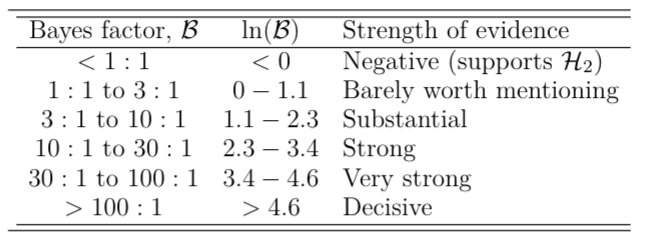

But note:
  * These are just **definitions of conventions**, i.e., a way to give a quantitative meaning to qualitative phrases.
  * The odds ratio **compares** the models, it doesn't tell us about the *absolute* goodness of fit: model A can be 100x better than model B, but still be pretty lousy.
  * Remember: "***GIGO***" ***= Garbage In, Garbage Out***. If we use our powerful statistics to rank a bunch of lousy models, that's our fault.

### Hypothesis Testing

In *hypothesis testing* we are essentially comparing a model, $M_1$, to its complement.  That is $p(M_1) + p(M_2) = 1$.  If we take $M_1$ to be the "null" (default) hypothesis (which is generally that, for example, a correlation does *not* exist), then we are asking whether or not the data reject the null hypothesis.

- In **classical hypothesis testing** we can ask whether or not a single model provides a good description of the data.  
- In **Bayesian hypothesis testing**, we need to have an alternative model to compare to.

---

### Example of Cauchy Versus Gaussian Model Comparison <a class="anchor" id="twoa"></a>

<font color='red'>Execute the following cell to draw a sample from a Cauchy distribution (remember, it has heavy tails!) and perform Bayesian Model Comparison for Cauchy and Gaussian models.</font> The Bayesian evidence is computed as a direct brute-force numerical integral over parameter space-- no MCMC methods are used here.

Results for first 10 points:
  L(M = Cauchy) = 1.18e-12 +/- 5.39e-16
  L(M = Gauss)  = 8.09e-13 +/- 7.45e-16
Bayesian odds ratio of Cauchy-versus-Gaussian Models = 1.45 +/- 0.00134


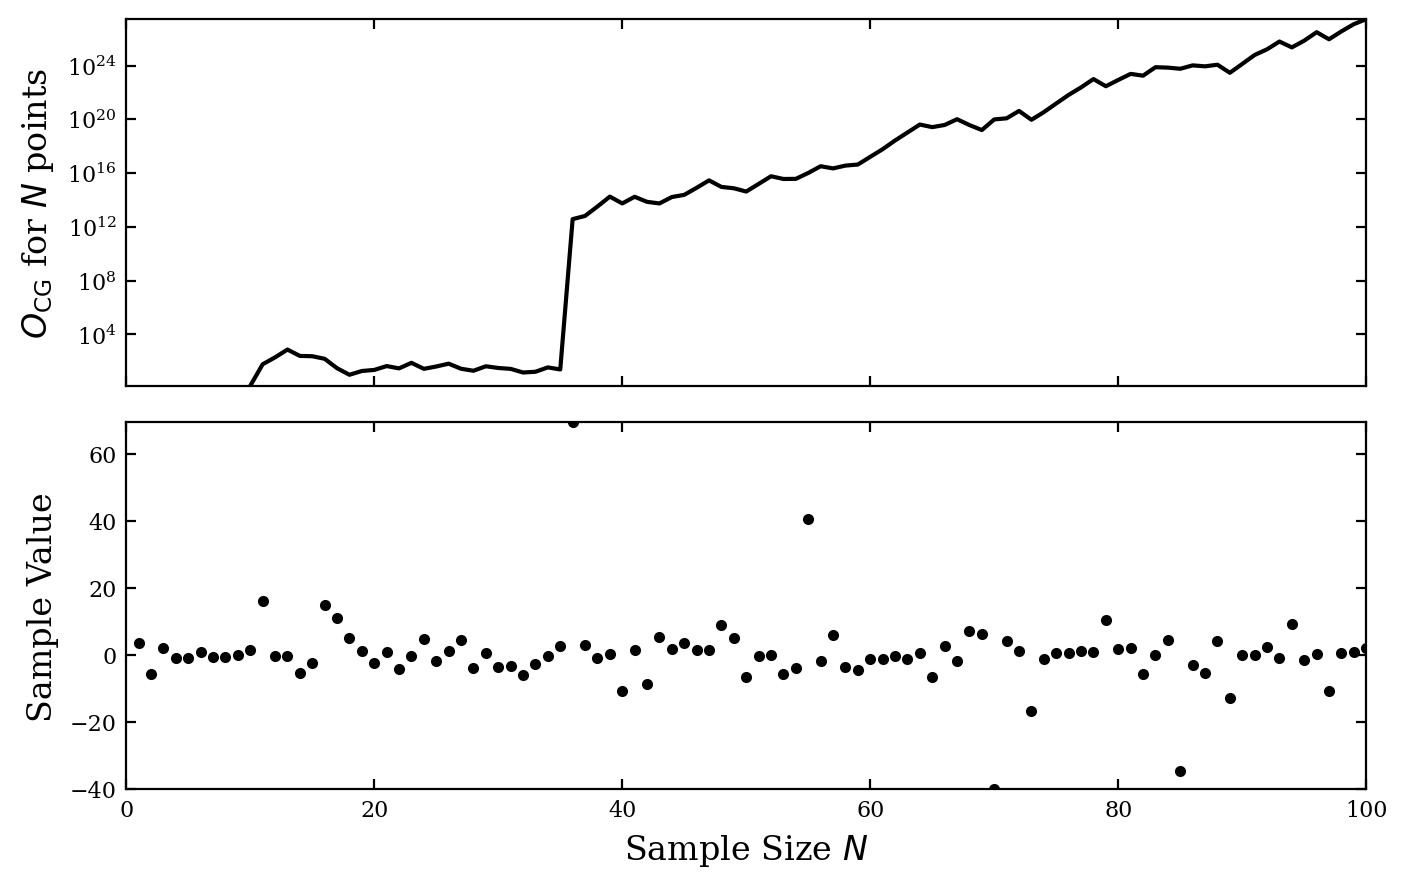

In [11]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from scipy.stats import cauchy, norm
from scipy import integrate

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)


def logL_cauchy(xi, gamma, mu,
                mu_min=-10, mu_max=10, sigma_min=0.01, sigma_max=100):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(gamma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    prior_normalization = - (np.log(mu_max - mu_min)
                             + np.log(np.log(sigma_max / sigma_min)))

    return (prior_normalization
            - n * np.log(np.pi)
            + (n - 1) * np.log(gamma)
            - np.sum(np.log(gamma ** 2 + (xi - mu) ** 2), 0))


def logL_gaussian(xi, sigma, mu,
                  mu_min=-10, mu_max=10, sigma_min=0.01, sigma_max=100):
    """Equation 5.57: gaussian likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    prior_normalization = - (np.log(mu_max - mu_min)
                             + np.log(np.log(sigma_max / sigma_min)))

    return (prior_normalization
            - 0.5 * n * np.log(2 * np.pi)
            - (n + 1) * np.log(sigma)
            - np.sum(0.5 * ((xi - mu) / sigma) ** 2, 0))


def calculate_odds_ratio(xi, epsrel=1E-8, epsabs=1E-15):
    """
    Compute the odds ratio by perfoming a double integral
    over the likelihood space.
    """
    gauss_Ifunc = lambda mu, sigma: np.exp(logL_gaussian(xi, mu, sigma))
    cauchy_Ifunc = lambda mu, gamma: np.exp(logL_cauchy(xi, mu, gamma))

    I_gauss, err_gauss = integrate.dblquad(gauss_Ifunc, -np.inf, np.inf,
                                           lambda x: 0, lambda x: np.inf,
                                           epsabs=epsabs, epsrel=epsrel)
    I_cauchy, err_cauchy = integrate.dblquad(cauchy_Ifunc, -np.inf, np.inf,
                                             lambda x: 0, lambda x: np.inf,
                                             epsabs=epsabs, epsrel=epsrel)

    if I_gauss == 0:
        O_CG = np.inf
        err_O_CG = np.inf
    else:
        O_CG = I_cauchy / I_gauss
        err_O_CG = O_CG * np.sqrt((err_gauss / I_gauss) ** 2)

    return (I_gauss, err_gauss), (I_cauchy, err_cauchy), (O_CG, err_O_CG)


#------------------------------------------------------------
# Draw points from a Cauchy distribution
np.random.seed(44)
mu = 0
gamma = 2
xi = cauchy(mu, gamma).rvs(100)

#------------------------------------------------------------
# compute the odds ratio for the first 10 points
((I_gauss, err_gauss),
 (I_cauchy, err_cauchy),
 (O_CG, err_O_CG)) = calculate_odds_ratio(xi[:10])

print("Results for first 10 points:")
print("  L(M = Cauchy) = %.2e +/- %.2e" % (I_cauchy, err_cauchy))
print("  L(M = Gauss)  = %.2e +/- %.2e" % (I_gauss, err_gauss))
print("Bayesian odds ratio of Cauchy-versus-Gaussian Models = %.3g +/- %.3g" % (O_CG, err_O_CG))

#------------------------------------------------------------
# calculate the results as a function of number of points
Nrange = np.arange(10, 101, 1)
Odds = np.zeros(Nrange.shape)
for i, N in enumerate(Nrange):
    res = calculate_odds_ratio(xi[:N])
    Odds[i] = res[2][0]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8, 5))
fig.subplots_adjust(hspace=0.1)

ax1 = fig.add_subplot(211, yscale='log')
ax1.plot(Nrange, Odds, '-k')
ax1.set_ylabel(r'$O_\mathrm{CG}$ for $N$ points', fontsize=12)
ax1.set_xlim(0, 100)
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_locator(plt.LogLocator(base=10000.0))

ax2 = fig.add_subplot(212)
ax2.scatter(np.arange(1, len(xi) + 1), xi, lw=0, s=16, c='k')
ax2.set_xlim(0, 100)
ax2.set_xlabel('Sample Size $N$', fontsize=12)
ax2.set_ylabel('Sample Value', fontsize=12)

plt.show() 

The odds ratio for the first 10 points is very close to unity ($O_{CG} = 1.45$) and is therefore inconclusive.
 
***Why do we get an inconclusive odds ratio?*** 
- With only 10 points, the probability of drawing at least one point far away from the mean, which would strongly argue against the Gaussian model, is fairly small. 
- As the number of data values is increased, the ability to discriminate between the models increases, too. 
- As the above figure shows, when we increase the size of the observed sample, the odds ratio quickly favors the  Cauchy over the Gaussian model.

### Example of Coin Flip Bayesian Model Comparison <a class="anchor" id="twob"></a>

Let's look at an example using coin flips. Let's assume we have $N$ draws and $k$ are "success" (say, heads). 

We will compare two hypotheses:

- **M1**: the coin has a known heads probability $b_\ast$ (say, a fair coin with $b_\ast=0.5$), with a prior given by a delta function, $\delta(b-b_\ast)$,
- **M2**: the heads probability $b$ is unknown, with a uniform prior in the range 0–1.

Basically in **M1** we know about the fairness of the coin. In **M2** we don't know anything about the fairness of the coin.

The model that we need (parametrized by the probability of success $b$, with $k$ successes) is the *binomial distribution*:

  $$    p(k\,|\,b, N) = \frac{N!}{k! \, (N-k)!} \, b^k \, (1-b)^{N-k} $$

For model **M2** the prior for $b$ is flat in the range 0-1 and the product of the data likelihood and prior is same as above. However, for model **M1** the prior is a  delta function $\delta(b-b_\ast)$ and we get for the product of the data likelihood and prior (which picks out $b=b_\ast$) 

$$    p(k\,|\,b_\ast, N, M1)\,p(b|M1, I) = \frac{N!}{k! \, (N-k)!} \, b_\ast^k \, (1-b_\ast)^{N-k}. $$

Consequently, the **odds ratio** is given by 

$$ O_{21} = \int_0^1 \left(\frac{b}{b_\ast}\right)^k \left(\frac{1-b}{1-b_\ast}\right)^{N-k} db, $$

as illustrated in the following figure. 

 
![Ivezic, Figure 5.1](http://www.astroml.org/_images/fig_odds_ratio_coin_1.png)

This figure (from the textbook) illustrates the behavior of $O_{21}$ as a function of $k$ for two different values of $N$ and for two different values of $b_\ast$: $b_\ast = 0.5$  (**M1**: the coin is fair) and $b_\ast = 0.1$ (**M1**: the coin is biased to tails). 

*The ability to distinguish  the two hypothesis **improves** with the sample size.*

For example:
- when $b_\ast = 0.5$ and $k/N = 0.1$ ($k=1$ on the left and $k=2$ on the right), the odds ratio in favor of **M2** increases from $\sim 9$ for $N=10$ to $\sim 263$ for $N=20$. 
- when k = $b_\ast N$, the odds ratio is $0.37$ for $N=10$ and 0.27 for $N=20$. 
- **the simpler model is favored by the data**, and the support strengthens with the sample size. 

**NOTE** 
- *$O_{21}= \sqrt{\pi/(2N)}$ when k = $b_\ast N$ and $b_\ast = 0.5$.* 
- To build strong evidence that a coin is fair, $O_{21} < 0.1$, it takes as many as $N > 157$ tosses. 
- With N = 10,000, the heads probability of a fair coin is measured with a precision of 1% and the corresponding odds ratio is $O_{21} \approx 1/80$.

***Frequentist Versus Bayesian***

In the **frequentist approach**, we ask whether we can reject the "null hypothesis" that our coin is fair. Specifically, we ask whether a given $k$ is a very unusual outcome (at some significance level $\alpha$, say $\alpha=0.05$) for a fair coin with $b_\ast = 0.5$ and with a given N. 

In the **Bayesian approach**, we offer an alternative hypothesis that the coin has an unknown heads probability. While this probability can be estimated from provided data ($b_0$), **we consider all the possible values** of $b_0$ when comparing the two proposed hypotheses. 

## Approximate Bayesian Model Comparison <a class="anchor" id="three"></a>

While the full *Odds Ratio* is the ultimate goal, it can be costly to compute. So we have some *approximate methods* that balance between ***goodness of fit*** and ***model complexity***. 

### Akaike information criterion (AIC) 

We've seen this before! 

$${\rm AIC} \equiv -2 \ln [L_0(M)] + 2k + \frac{2k(k+1)}{N-k-1}.$$

### Bayesian information criterion (BIC)

- The BIC is new to us. 
- It can be derived from the Bayesian odds ratio by assuming that the likelihood is Gaussian (see $\S$5.4.2 in textbook for details). 
- It's easier to compute than the odds ratio because it is based on the maximum value of the likelihood, $L_0(M)$, rather than on the integration of the likelihood over the full parameter space (i.e. evidence $E(M)$). 

For $N$ data points and a model with $k$ parameters,

$${\rm BIC} \equiv -2 \ln [L_0(M)] + k \ln N.$$ 

where 
- the 1st term is equal to the model's $\chi^2$ (under the assumption of normality; note that this is not $\chi^2$ per degree of freedom!) and 
- the 2nd term on the RHS penalizes complex models relative to simple ones.

When two models are compared, **the model with the smaller BIC/AIC value wins**. If the models are equally successful in describing the data (i.e., they have the same value of $L_0(M)$), then the model with fewer free parameters wins. 

Let's use BIC to choose the best polynomial from the earlier line fitting example. 
Starting with

$${\rm BIC} = \chi^2 + k \ln N,$$ 

with $N=20$ we have:

<pre>
     model     chi2    k   k*ln(N)   BIC   
     ------------------------------------
    linear    11.32    2    5.99    17.31   
  quadratic    9.46    3    8.99    18.45   
     cubic     8.99    4   11.98    20.97  
</pre>

Therefore, **the improvement in $\chi^2$ for the quadratic model**, relative to the linear model, **is not large enough to justify another free model parameter.**

**BUT NOTE!** 
- The BIC and AIC are approximations and might not be valid if the underlying assumptions are not met.
- Furthermore, unlike the odds ratio, both of them penalize unconstrained parameters. The odds ratio does not care about unconstrained parameters.
- In general, it is better to compute the odds ratio when computationally feasible. 